In [1]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import MultiLabelBinarizer
from collections import defaultdict,OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import glob
import os
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LinearRegression
from scipy.stats import entropy
import string
import datetime
import numpy as np
from joblib import Parallel, delayed
from time import sleep
from utils import *
from sklearn.mixture import BayesianGaussianMixture
import scipy.stats as stats
import importlib
import utils
import warnings
from itertools import combinations

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams.update({'font.size': 14})
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)
import networkx as nx

import leidenalg
import igraph as ig

# importlib.reload(utils)


In [2]:
groups = {
    'ExCo': ['ceo', 'cto', 'cfo', 'coo', 'cmo', 'cio', 'cso', 'cpo', 'cco', 'cro', 'svp', 'evp', 'cdo', 'cbo', 'cxo'],
    'Founder': ['founder'],
    'Engineering': ['software engineer', 'data scientist'],
    'Leadership': ['president', 'managing director', 'director', 'vp', 'chairman', 'executive director', 'general manager', 'vp engineering'],
    'Board': ['board member', 'member board director', 'board directors', 'chairman board', 'advisory board member', 'board observer'],
    'Ownership': ['owner', 'partner', 'managing partner', 'founding partner'],
    'Investor':['investor'],
    'Advisory': ['advisor', 'consultant'],
    'Other': ['member', 'team member', 'associate', 'product manager', 'principal']
}

dimension_labels = list(groups.keys())

colors = sns.color_palette(
                            "tab10", 
                            n_colors=len(dimension_labels)
                          )

## Loading data

In [3]:
df_org          = pd.read_csv('../data/organizations.csv')
df_jobs         = pd.read_csv('../data/jobs.csv')
df_people       = pd.read_csv('../data/people.csv')
df_fund_rounds  = pd.read_csv('../data/funding_rounds.csv')
df_ipos         = pd.read_csv('../data/ipos.csv')
df_acquisitions = pd.read_csv('../data/acquisitions.csv')
df_jobs_cleaned = pd.read_csv('../data/jobs_cleaned.csv',
                              converters={'group': str_to_list})

df_org_foundation = df_org[['uuid', 'founded_on','country_code','city','total_funding_usd']]
# Convert the 'founded_on' column to datetime
df_org_foundation['founded_on'] = pd.to_datetime(df_org_foundation['founded_on'], errors='coerce')
# Drop rows with NaN values (including out-of-bounds datetime)
df_org_foundation = df_org_foundation[df_org_foundation['founded_on'].notna()]
df_org_foundation = df_org_foundation[df_org_foundation['country_code'].notna()]


FileNotFoundError: [Errno 2] No such file or directory: 'data_output/jobs_cleaned.csv'

### Creating the dendogram

In [165]:
# ---- Parameters ---- #
start_year = 2010  # Define the start year for filtering organizations and jobs
end_year = start_year + 1  # Define the end year for filtering (one year range)

# Filter the organizations and jobs based on the specified year range
df_org_filtered = filter_by_year_range(df_org_foundation, 'founded_on', start_year, end_year)
df_jobs_filtered = filter_by_year_range(df_jobs_cleaned, 'started_on', start_year, end_year)

# Define the minimum counts for cities and jobs to be included in the analysis
minimum_city_count = 100
minimum_jobs_count = 100

# ---- Filtering ----- #

# Count the occurrences of each city in the filtered organization DataFrame
city_counts = df_org_filtered['city'].value_counts()

# Filter the cities to include only those with counts greater than or equal to the minimum_city_count
filtered_city_counts = city_counts[city_counts >= minimum_city_count]

# Filter the organization DataFrame to include only the cities that meet the minimum count criteria
df_org_filtered = df_org_filtered[df_org_filtered.city.isin(filtered_city_counts.index.tolist())]

# Merge the filtered organization and jobs DataFrames on the organization UUID
df_merge = pd.merge(df_org_filtered, df_jobs_filtered, left_on='uuid', right_on='org_uuid')

# Explode the 'group' column into separate rows, one for each group associated with an organization
exploded = df_merge.explode('group').reset_index(drop=True)

# Count the occurrences of unique elements, grouped by 'city' and 'group'
group_counts = exploded.groupby(['city', 'group']).size().reset_index(name='count')

# Pivot the data to have the groups as columns, with cities as the index and counts as values
pivoted = group_counts.pivot(index='city', columns='group', values='count').fillna(0)

# Calculate the total number of groups for each city
city_totals = pivoted.sum(axis=1)

# Filter the pivoted DataFrame to include only cities with a total group count greater than or equal to the minimum count
filtered_pivoted = pivoted[city_totals >= minimum_jobs_count]

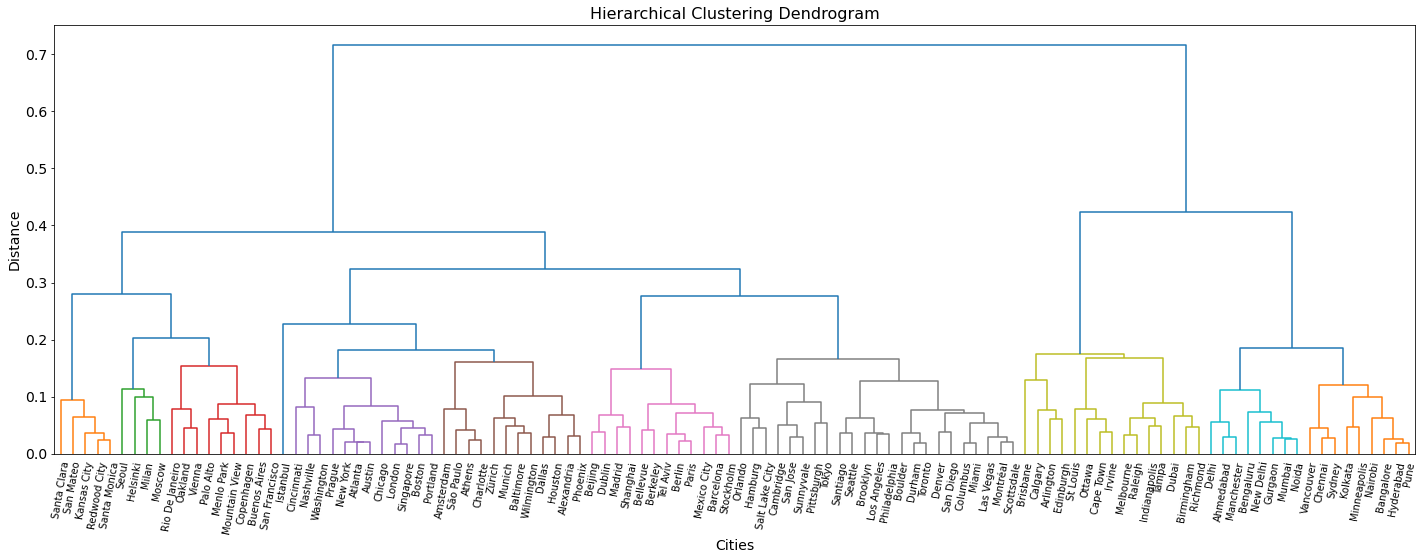

In [166]:
normalized_pivoted = filtered_pivoted.apply(lambda row: row / row.sum(), axis=1)
Z = linkage(normalized_pivoted, method='ward')
createDendogram(normalized_pivoted,Z,threshold = 0.18)

### Show the fingerprints per cluster

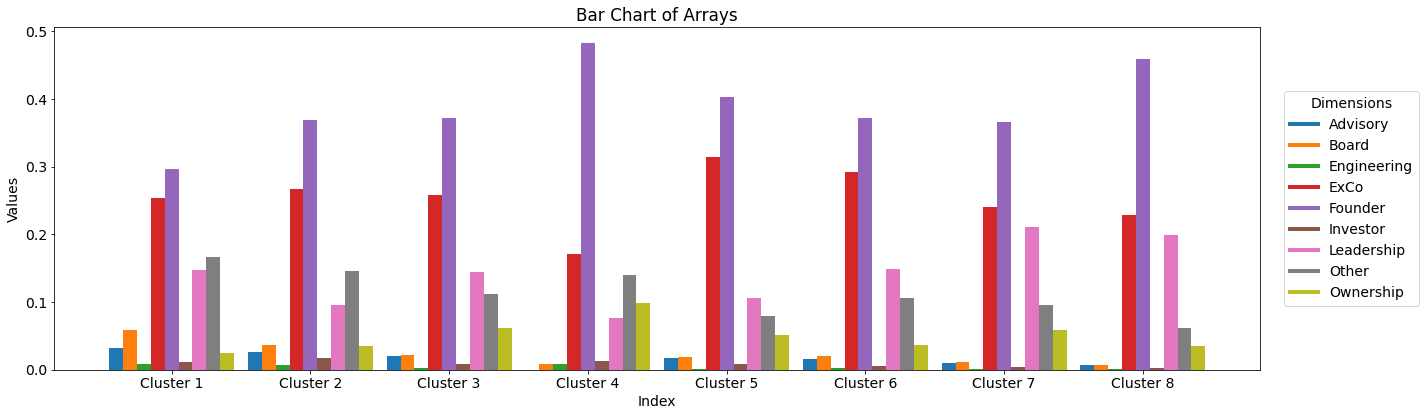

In [167]:
cluster_cities = plotClusters(filtered_pivoted,
              list(filtered_pivoted.columns),
              sns.color_palette("tab10", n_colors=len(filtered_pivoted.columns)),
              Z,
              normalized=True, 
              difference=False,
              clusters = 8,
              return_cities=True
            )       

## Network Fingerprints

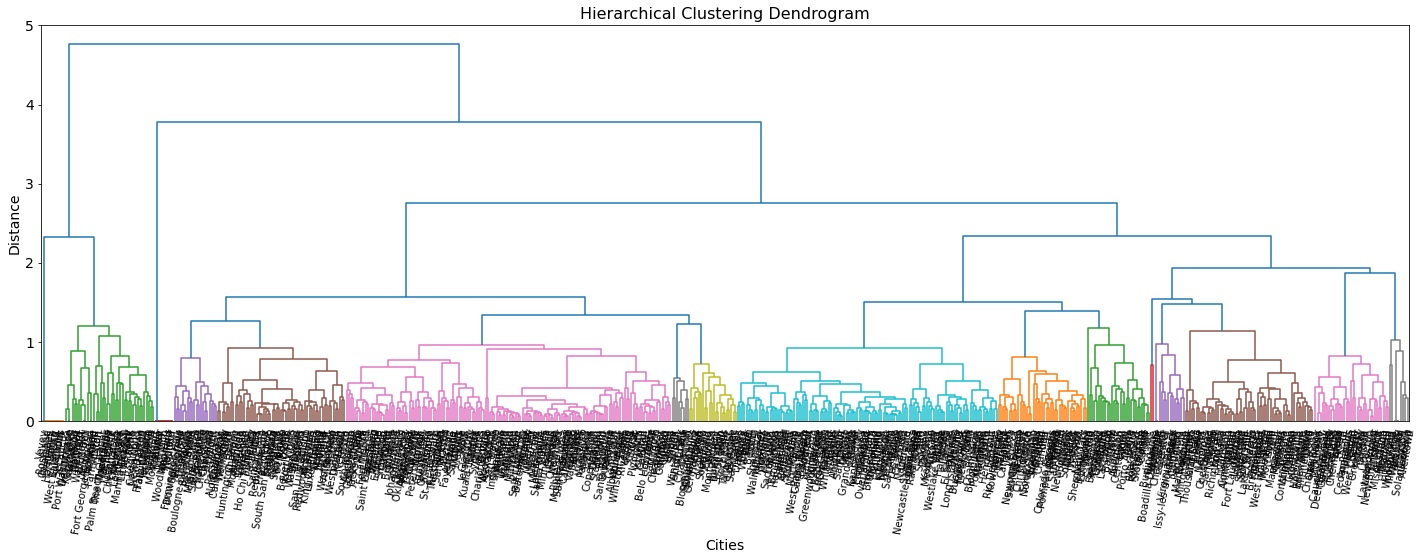

/Users/vc/Research/caratterizzazione-sistemi-innovativi/utils.py:212: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


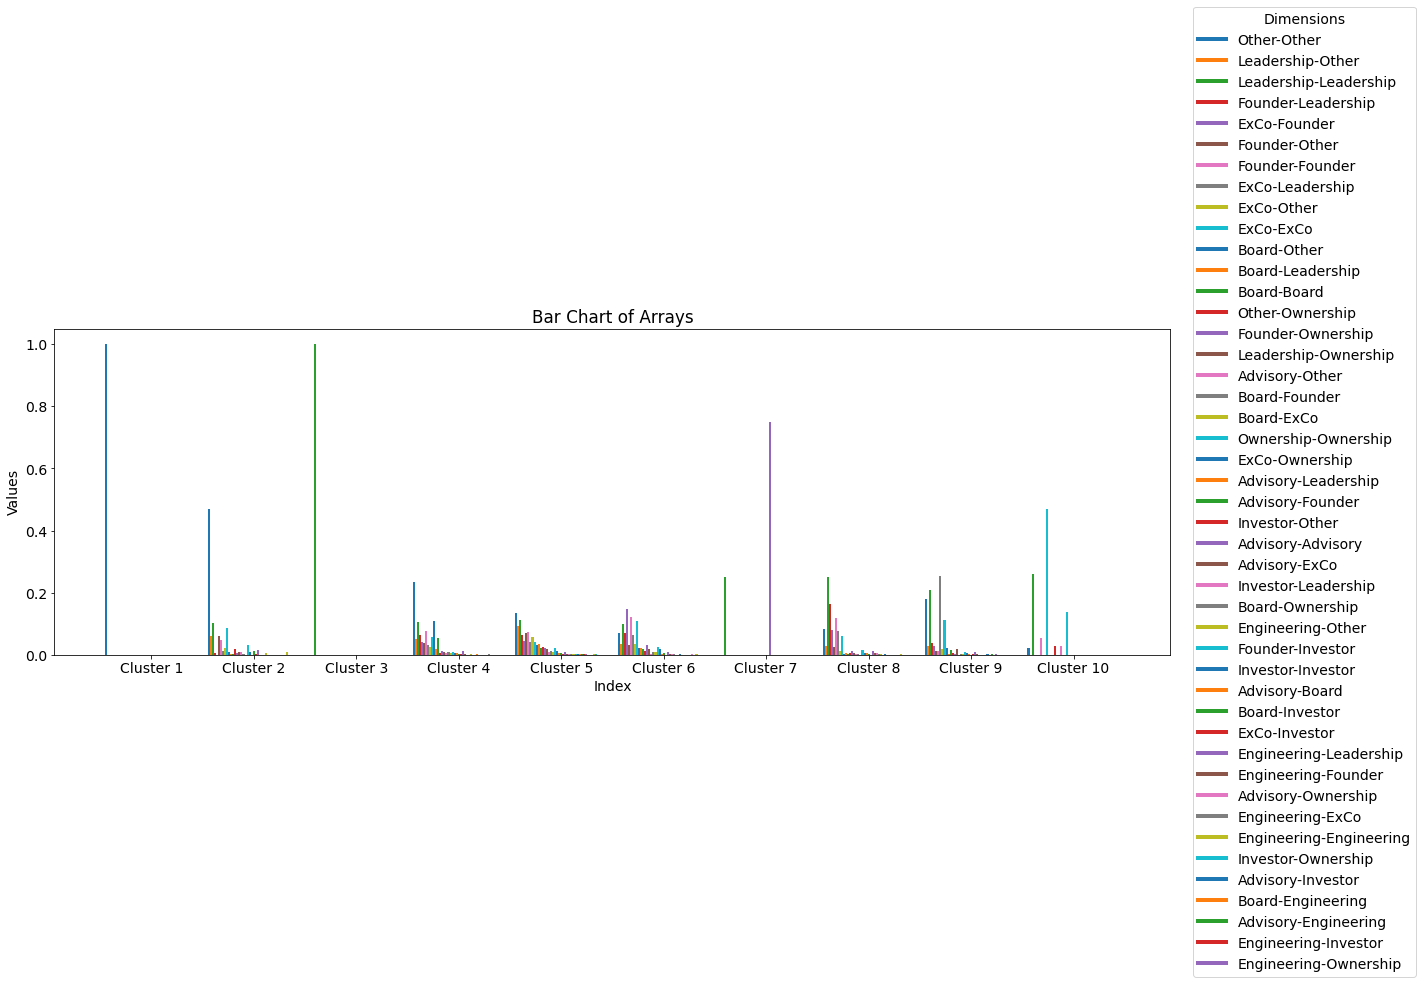

In [185]:
year = 2010
categories = ['-'.join(sorted(i)) for i in list(combinations(list(groups.keys()),2))]
categories.extend([i+'-'+i for i in list(groups.keys())])
categories = sorted(categories)

df = networkFingerprint(df_org_foundation,df_jobs_cleaned,year,city_to_consider='New York')

network_df = networkFingerprint(df_org_foundation,df_jobs_cleaned,year,city_to_consider='all')
Z = linkage(network_df, method='ward')
createDendogram(network_df,Z,threshold = 1.2)

cluster_cities = plotClusters(network_df,
              list(network_df.columns),
              sns.color_palette("tab10", n_colors=len(network_df.columns)),
              Z,
              normalized=True, 
              difference=False,
              bar_width = 0.02,
              clusters = 10,
              return_cities=True
              )       

## Entropy and city trend

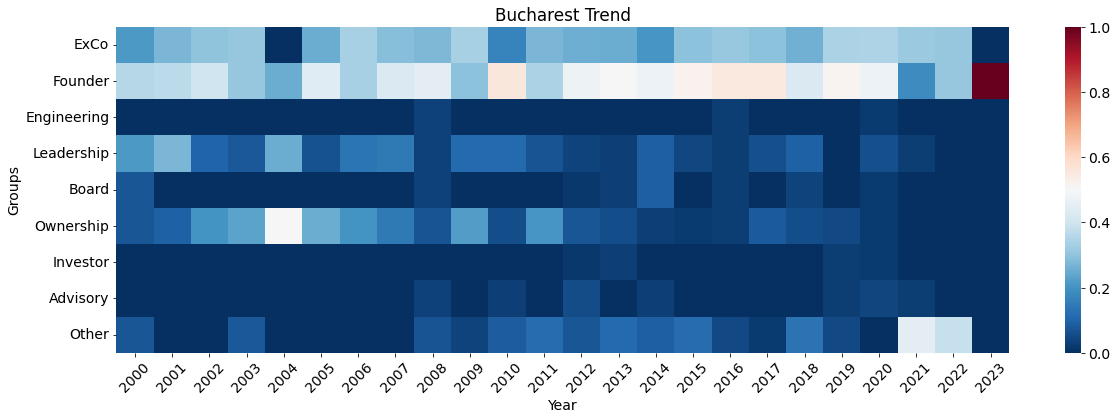

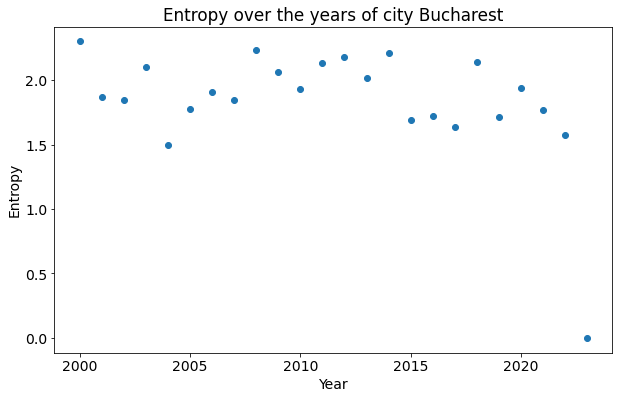

In [171]:
city = 'Bucharest'
start_year = 2000
end_year = 2024

matrix = np.zeros((end_year-start_year,len(dimension_labels)))

# List of unique groups (dimension labels)
unique_groups = dimension_labels

# -------

# Iterate through each year from 2000 to 2023
for year_index, year in enumerate(range(start_year, end_year)):
    tmp_end_year = year  # Set the end year to the start year (single year filtering)
    
    # Filter organizational data by the year range
    df_org_filtered = filter_by_year_range(df_org_foundation, 'founded_on', year, tmp_end_year)
    
    # Filter job data by the year range
    df_jobs_filtered = filter_by_year_range(df_jobs_cleaned, 'started_on', year, tmp_end_year)

    # Merge filtered organization and job data on organization UUIDs
    df_merge = pd.merge(df_org_filtered[df_org_filtered.city == city], df_jobs_filtered, left_on='uuid', right_on='org_uuid')

    # Explode the 'groups' column into separate rows
    exploded = df_merge.explode('group').reset_index(drop=True)

    # Count occurrences of unique elements grouped by 'city' and 'group'
    group_counts = exploded.groupby(['city', 'group']).size().reset_index(name='count')

    # Normalize the group counts by the total counts within the city
    if not group_counts.empty:
        group_counts['normalized_count'] = group_counts['count'] / group_counts['count'].sum()

        # Assign counts to the appropriate position in the matrix
        for i, group in enumerate(unique_groups):
            if group in group_counts['group'].values:
                matrix[year_index, i] = group_counts[group_counts['group'] == group]['normalized_count'].values[0]

# Transpose the matrix for better visualization
transposed_matrix = matrix.T

# Create a DataFrame from the transposed matrix with years as columns and unique groups as rows
heatmap_data = pd.DataFrame(transposed_matrix, columns=range(start_year, end_year), index=unique_groups)

# Calculate entropy for each group of counts in the matrix
entropies = [entropy(group_counts, base=2) for group_counts in matrix]

heatmapPlot(heatmap_data,city)
entropyPlot(entropies,city)

In [13]:
l_coeff, city_coeff = entropyTrend(filtered_pivoted, 2000, 2024, df_jobs_cleaned, df_org_foundation)

/Users/vc/miniforge3/envs/atomico/lib/python3.8/site-packages/scipy/stats/_entropy.py:77: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/Users/vc/miniforge3/envs/atomico/lib/python3.8/site-packages/scipy/stats/_entropy.py:77: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/Users/vc/miniforge3/envs/atomico/lib/python3.8/site-packages/scipy/stats/_entropy.py:77: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/Users/vc/miniforge3/envs/atomico/lib/python3.8/site-packages/scipy/stats/_entropy.py:77: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/Users/vc/miniforge3/envs/atomico/lib/python3.8/site-packages/scipy/stats/_entropy.py:77: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [16]:
dict(sorted(city_coeff.items(), key=lambda x: x[1]))

{'Bucharest': -0.027060951939936413,
 'Milano': -0.024863273145516892,
 'Kolkata': -0.02379346837333907,
 'St Louis': -0.020457195031923833,
 'San Francisco': -0.01815999881704951,
 'Santa Monica': -0.017122331645597826,
 'San Jose': -0.017020516780140885,
 'San Mateo': -0.016731480922744863,
 'Minneapolis': -0.015998530359618405,
 'Indianapolis': -0.01387090045183126,
 'Portland': -0.013860493069850995,
 'Stockholm': -0.01362487041676256,
 'Mountain View': -0.01255024141219121,
 'Hamburg': -0.01193653039339505,
 'Phoenix': -0.010896016147749056,
 'Boca Raton': -0.010855136401923616,
 'Dublin': -0.010566451019713086,
 'Chennai': -0.009951703538333974,
 'Birmingham': -0.009345159447447864,
 'Manchester': -0.008991984592363627,
 'Calgary': -0.008883817606404287,
 'Seattle': -0.00876463767028306,
 'Copenhagen': -0.008533385766609676,
 'Las Vegas': -0.008302564358978495,
 'Cambridge': -0.00814201047472121,
 'Pune': -0.00810467054917316,
 'Noida': -0.008040595262091929,
 'New Delhi': -0.007

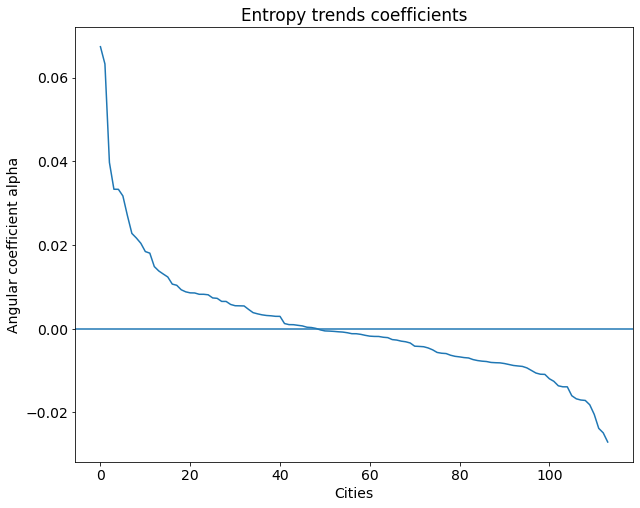

In [14]:
entropyTrendPlot(l_coeff)

## Network fingerprints trend analysis

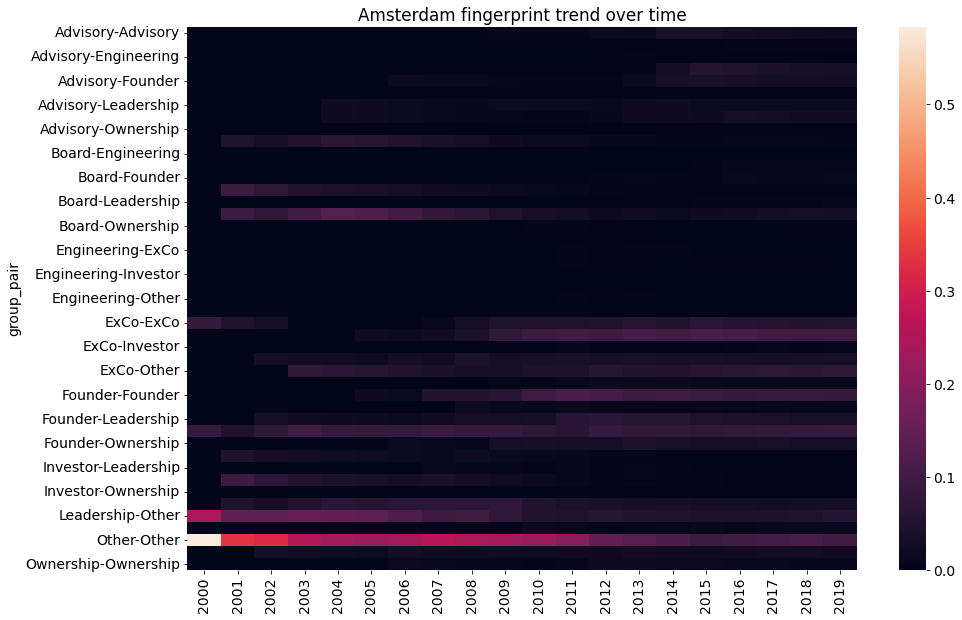

In [20]:
start_year = 2000
end_year   = 2020
city = 'Amsterdam'

df = pd.concat([networkFingerprint(df_org_foundation,df_jobs_cleaned,year,city_to_consider=city) for year in range(start_year,end_year)])
df_2 = df.reindex(categories, axis=1, fill_value=0)
df_2 = df_2.fillna(0)
df_2.index = [i for i in range(start_year,end_year)]


plt.figure(figsize=(15,10))
plt.title(city+' fingerprint trend over time')
sns.heatmap(df_2.T);

In [21]:
entropy_dict = defaultdict(list)
angular_coeff_dict = defaultdict(float)

In [ ]:
for city in list(filtered_pivoted.index.tolist()):
    # if city in list(angular_coeff_dict.keys()):
    #     continue
    try:
        df = pd.concat([networkFingerprint(df_org_foundation,df_jobs_cleaned,year,city_to_consider=city) for year in range(start_year,end_year)])
        df_2 = df.reindex(categories, axis=1, fill_value=0)
        df_2 = df_2.fillna(0)
        df_2.index = [i for i in range(start_year,end_year)]
    except:
        print(city+', not enough startups')
        continue
    df_3 = df_2.reset_index(drop=True)
    df_3['Entropy'] = df_3.apply(calculate_entropy, axis=1)
    entropies = df_3['Entropy'].tolist()
    entropy_dict[city] = entropies
    angular_coeff_dict[city] = calculate_angular_coeff(entropies)
    print(city,calculate_angular_coeff(entropies))

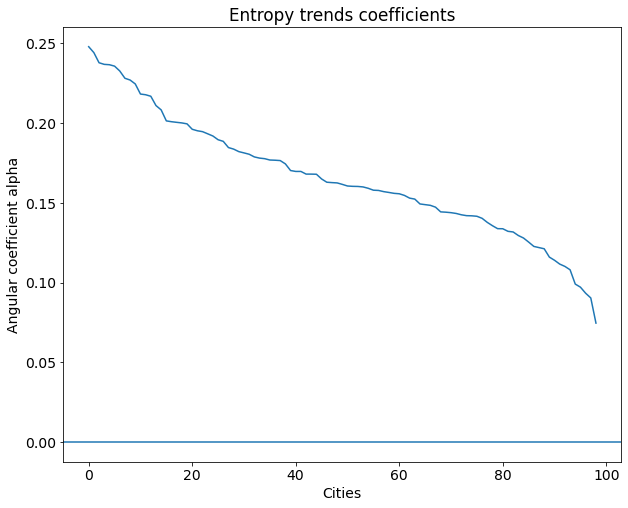

In [23]:
entropyTrendPlot(sorted(list(angular_coeff_dict.values())))

In [24]:
angular_coeff_dict

defaultdict(float,
            {'Ahmedabad': 0.11015999823063863,
             'Amsterdam': 0.22818499111838908,
             'Athens': 0.1337848490763665,
             'Atlanta': 0.14847684736264205,
             'Austin': 0.16973152914883977,
             'Bangalore': 0.18961980196363803,
             'Barcelona': 0.2327497286060508,
             'Bengaluru': 0.18052120578536518,
             'Berkeley': 0.11598961664658698,
             'Berlin': 0.24798572241580288,
             'Birmingham': 0.13384068703113697,
             'Boca Raton': 0.11161698616366367,
             'Boston': 0.16060219041341023,
             'Boulder': 0.23578337610839165,
             'Brooklyn': 0.174470692620223,
             'Brussels': 0.15706237801016873,
             'Buenos Aires': 0.22461125752909936,
             'Calgary': 0.16272267578469937,
             'Cambridge': 0.16805272083899803,
             'Charlotte': 0.14254179057314653,
             'Chennai': 0.15797210370664166,
             'Ch

# Acquisition analysis

In [172]:
def filterYear(df, date_column, year_s, delta=5):
    # Convert the date column to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df[date_column]):
        df[date_column] = pd.to_datetime(df[date_column])
        
    # Create the start and end date ranges
    year = pd.Timestamp(year=year_s, month=12, day=31)
    future = pd.Timestamp(year=year_s+delta, month=12, day=31)

    # Filter the DataFrame based on the date range
    filtered_df = df[(df[date_column] >= year) & (df[date_column] <= future)]

    return filtered_df

In [191]:
year = 2015

fund_rounds = df_fund_rounds[['raised_amount_usd','announced_on','org_uuid']].dropna()
funding_df = filter_up_to_year(fund_rounds,'announced_on',year)

df_org_foundation = df_org_foundation.rename(columns={'uuid':'org_uuid'})
org_foundation = filter_up_to_year(df_org_foundation,'founded_on',year)

acquisition_df = df_acquisitions[['acquiree_uuid','acquiree_city','acquired_on','price_usd']].rename(columns={'acquiree_uuid':'org_uuid',
                                                                                                              'acquiree_city':'city'}).dropna()
acquisition_filtered = filterYear(acquisition_df,'acquired_on',year,delta=5)


In [192]:
df1 = pd.DataFrame(pd.merge(funding_df,org_foundation).groupby('city')['raised_amount_usd'].sum()).reset_index()
df2 = acquisition_filtered.groupby('city')['price_usd'].sum().reset_index()

In [193]:
df_merge = pd.merge(df1,df2)

Text(0, 0.5, 'Acquisition value')

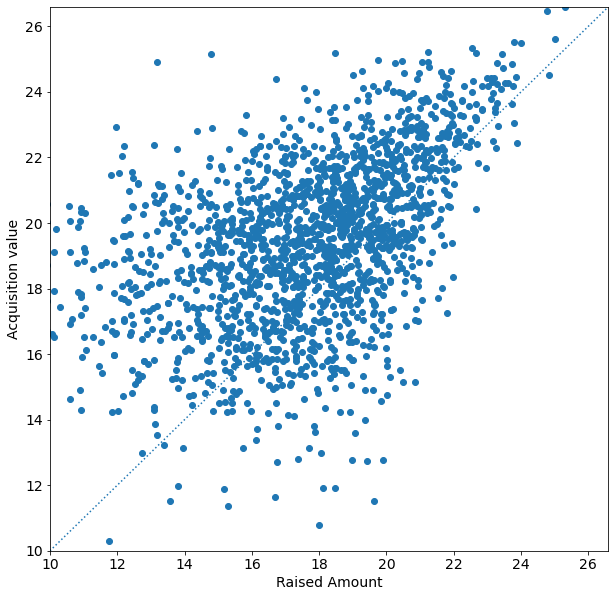

In [194]:
max_v = max(np.log(df_merge['raised_amount_usd']).max(),np.log(df_merge['price_usd']).max())
plt.figure(figsize=(10,10))
plt.xlim([10,max_v])
plt.ylim([10,max_v])
plt.scatter(np.log(df_merge['raised_amount_usd']),np.log(df_merge['price_usd']))
plt.plot([10,max_v],[10,max_v],':')
plt.xlabel('Raised Amount')
plt.ylabel('Acquisition value')

In [195]:
# import hdbscan
# # Create the HDBSCAN clustering
# clusterer = hdbscan.HDBSCAN(metric='euclidean', cluster_selection_method='eom')
# cluster_labels = clusterer.fit_predict(network_df)

# # Print the cluster labels
# print("Cluster labels:", cluster_labels)

# # Plot the dendrogram
# clusterer.condensed_tree_.plot(select_clusters=True)
# plt.title("Dendrogram")
# plt.show()


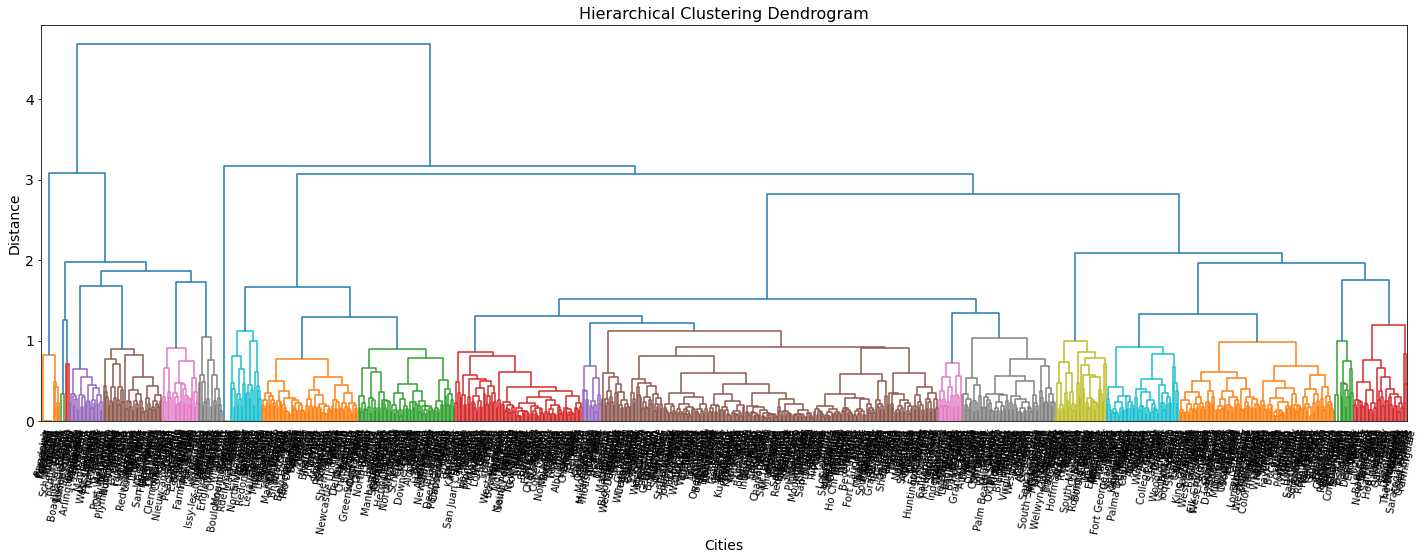

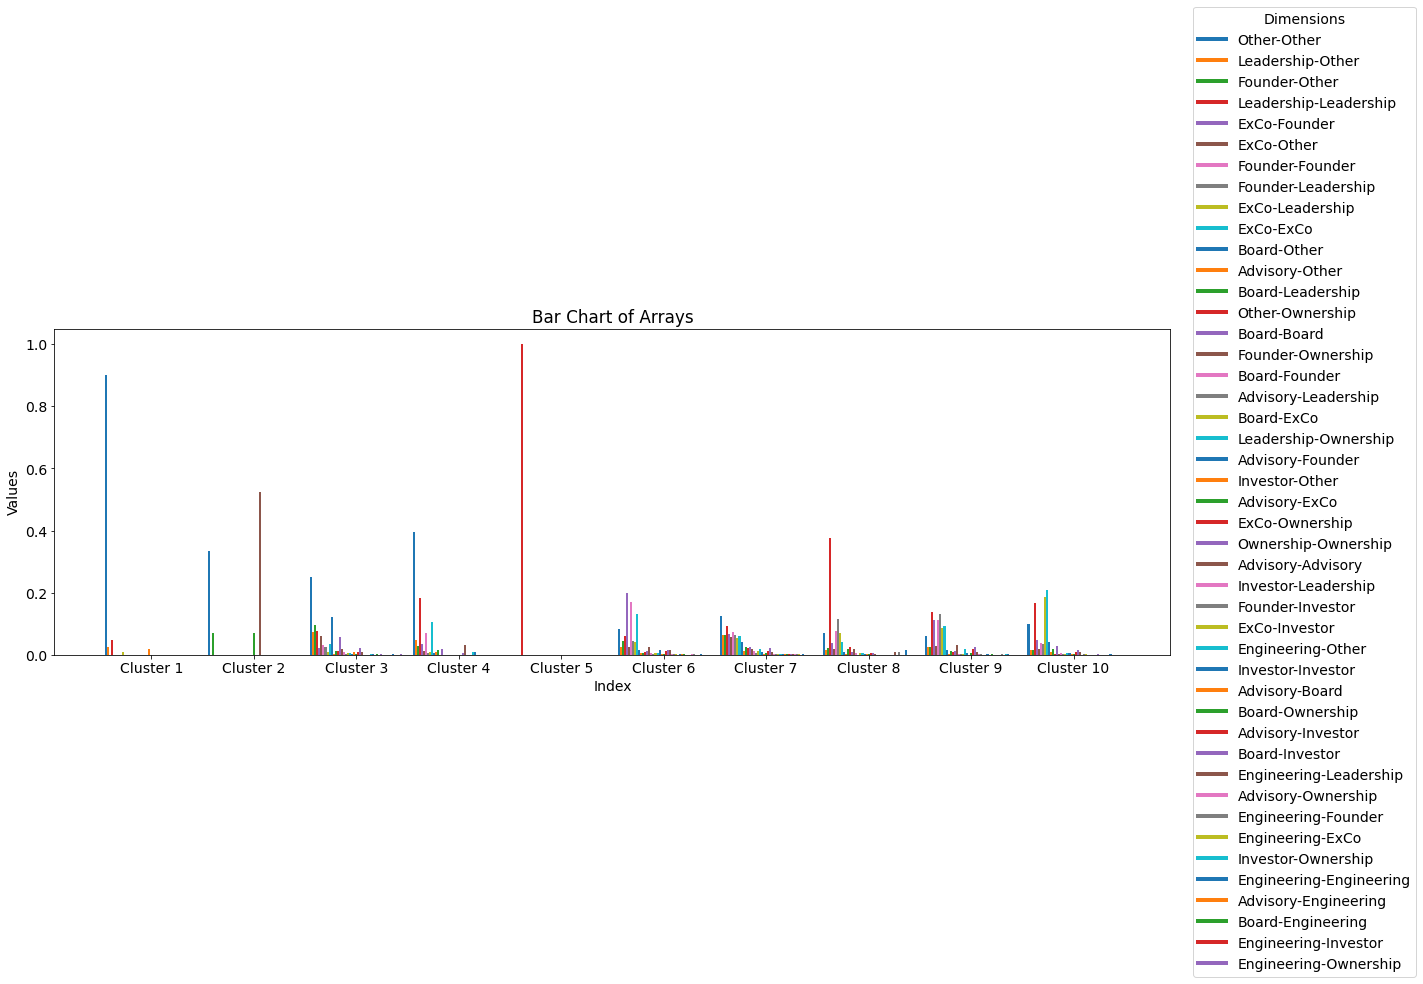

In [199]:
categories = ['-'.join(sorted(i)) for i in list(combinations(list(groups.keys()),2))]
categories.extend([i+'-'+i for i in list(groups.keys())])
categories = sorted(categories)

df = networkFingerprint(df_org_foundation,df_jobs_cleaned,year,city_to_consider='New York')

network_df = networkFingerprint(df_org_foundation,df_jobs_cleaned,year,city_to_consider='all')
Z = linkage(network_df, method='ward')
createDendogram(network_df,Z,threshold = 1.2)

cluster_cities = plotClusters(network_df,
              list(network_df.columns),
              sns.color_palette("tab10", n_colors=len(network_df.columns)),
              Z,
              normalized=True, 
              difference=False,
              bar_width = 0.02,
              clusters = 10,
              return_cities=True
              )    

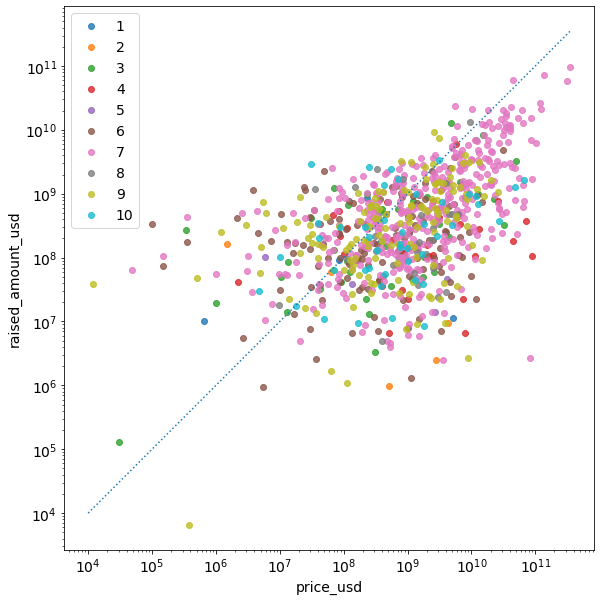

In [197]:
# Create a dictionary to map colors to keys
colors = {key: f"C{i}" for i, key in enumerate(cluster_cities.keys())}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))  # Square figure

# Plot the scatter plot
for key, city_list in cluster_cities.items():
    mask = df_merge['city'].isin(city_list)
    ax.scatter(df_merge.loc[mask, 'price_usd'], 
               df_merge.loc[mask, 'raised_amount_usd'], 
               color=colors[key], 
               label=key, 
               alpha=0.8)

# Set log scale for both axes
ax.set_xscale('log')
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('price_usd')
ax.set_ylabel('raised_amount_usd')

# Set aspect ratio to 1 (square)
ax.set_aspect('equal', adjustable='box')
max_v = max(df_merge['raised_amount_usd'].max(),df_merge['price_usd'].max())

plt.plot([1E4,max_v],[1E4,max_v],':')


# Add legend
ax.legend()

# Show the plot
plt.show()

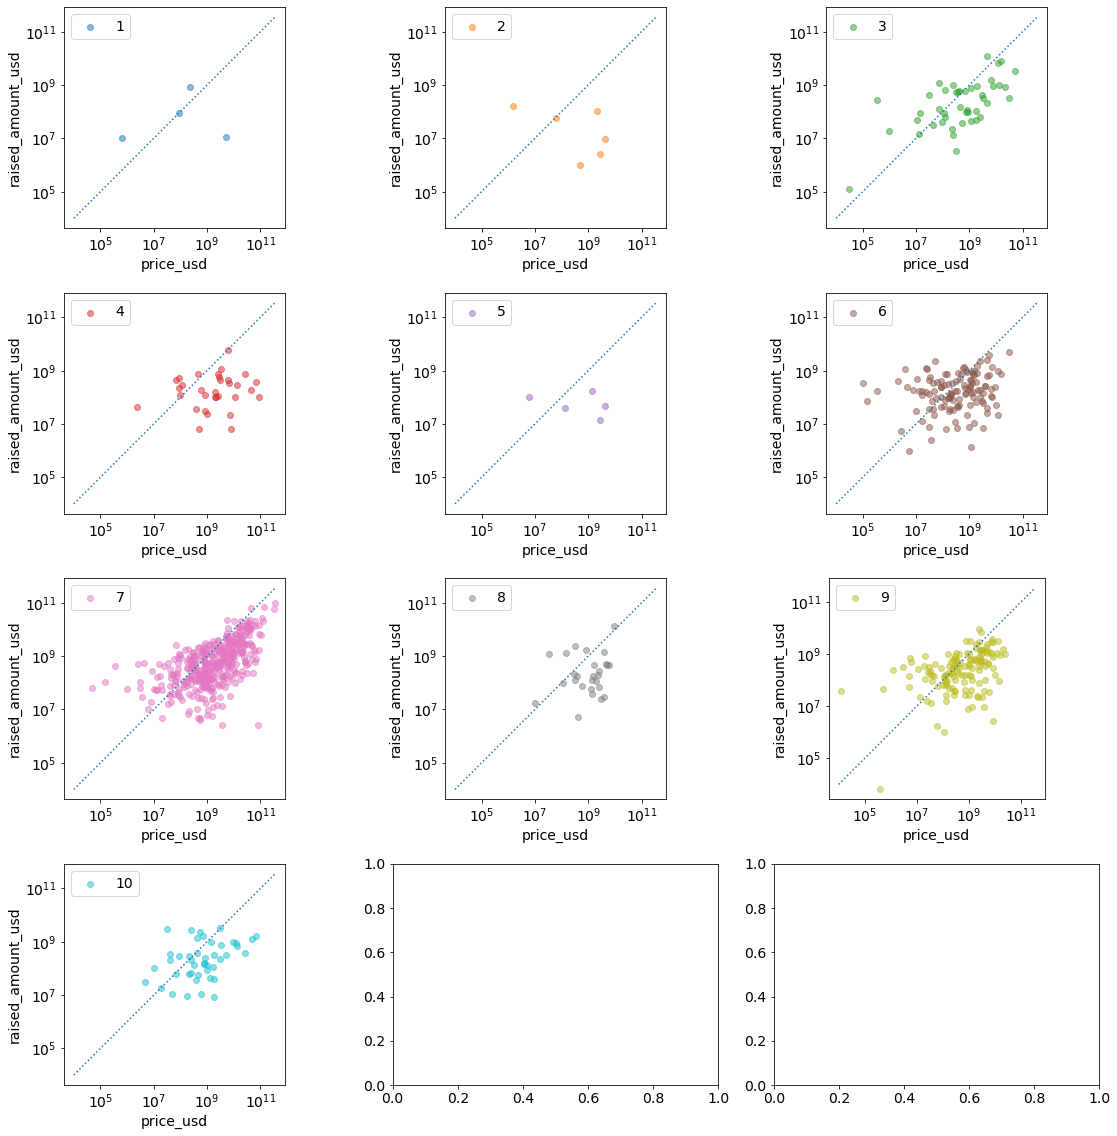

In [198]:
import numpy as np
from math import ceil

# Create a dictionary to map colors to keys
colors = {key: f"C{i}" for i, key in enumerate(cluster_cities.keys())}

# Calculate the number of rows and columns needed for the subplots
num_subplots = len(cluster_cities)
nrows = ceil(num_subplots ** 0.5)  # Square root of num_subplots, rounded up
ncols = ceil(num_subplots / nrows)

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16), squeeze=False)

# Iterate over the subplots and keys
for ax, (key, city_list) in zip(axes.flat, cluster_cities.items()):
    # Filter the dataframe for the current key
    mask = df_merge['city'].isin(city_list)

    # Plot the scatter plot on the current subplot
    ax.scatter(df_merge.loc[mask, 'price_usd'], df_merge.loc[mask, 'raised_amount_usd'], color=colors[key], label=key, alpha=0.5)

    # Set log scale for both axes
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Set axis labels
    ax.set_xlabel('price_usd')
    ax.set_ylabel('raised_amount_usd')

    # Set aspect ratio to 1 (square)
    ax.set_aspect('equal', adjustable='box')

    # Plot the bisectrice
 
    max_v = max(df_merge['raised_amount_usd'].max(),df_merge['price_usd'].max())

    ax.plot([1E4,max_v],[1E4,max_v],':')


    # Add legend
    ax.legend()

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.tight_layout()
# Show the plot
plt.show()

## Diversification vs Specialization

In [29]:
org_categories = df_org[['uuid', 'founded_on','country_code','category_list','category_groups_list','city']]
org_categories['founded_on'] = pd.to_datetime(org_categories['founded_on'], errors='coerce')
org_categories = org_categories[org_categories['founded_on'].notna()]
org_categories = org_categories[org_categories['category_groups_list'].notna()]
org_categories = org_categories[org_categories['category_list'].notna()]

In [97]:
year = 2020
df = org_categories.dropna(subset=['country_code'])
org_filtered = filter_up_to_year(df,'founded_on',year)[['city','category_list']]
org_filtered['category_list'] = org_filtered['category_list'].apply(lambda x: x.split(','))
df = org_filtered.explode('category_list').reset_index(drop=True)


matrix = pd.crosstab(df['city'], df['category_list'])
# Fill missing values with 0
matrix = matrix.fillna(0)

matrix[matrix > 1] = 1

M = matrix.values
cities = matrix.index

# # Sort the rows and columns
# sorted_rows = matrix.sum(axis=1).sort_values(ascending=False).index
# sorted_cols = matrix.sum(axis=0).sort_values(ascending=False).index
# # Create the heatmap
# plt.figure(figsize=(20, 10))
# heatmap = sns.heatmap(matrix.loc[sorted_rows, sorted_cols].head(1000))
# heatmap.tick_params(left=False, bottom=False)

# # Adjust the layout
# # heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
# plt.tight_layout()
# plt.show()

### Calculating the fitness and complexity

In [101]:
def updateFitness(X,Q):

    return X @ Q

def updateComplexity(X,F):

    F_1 = np.reciprocal(F)
    return np.reciprocal(X.T @ F_1)

def fitnessComplexity(X,n_rounds=100):

    F = np.ones(X.shape[0])
    Q = np.ones(X.shape[1])
    for i in range(n_rounds):
        F_tilde = updateFitness(X,Q)
        Q_tilde = updateComplexity(X,F)
        F = F_tilde / np.sum(np.abs(F_tilde))
        Q = Q_tilde / np.sum(np.abs(Q_tilde))

    return F,Q

In [102]:
f,q = fitnessComplexity(M)

In [103]:
# Create a dictionary from the two arrays
data = {'city': cities, 'value': f}

# Create a DataFrame
df = pd.DataFrame(data)

# Sort the DataFrame by 'value' in descending order
df = df.sort_values(by='value', ascending=False)

print(df)

                    city         value
45519       Philadelphia  2.499708e-01
11732           Cheswick  2.499708e-01
56962         St. John's  2.499708e-01
30668  L'ile-saint-denis  2.499708e-01
43595              Osaka  1.944449e-05
...                  ...           ...
12162              Chyby  1.116553e-89
46660            Pontian  1.116553e-89
12023          Chon Buri  1.116553e-89
46541          Poniatowa  1.116553e-89
38027             Miyako  1.116553e-89

[68166 rows x 2 columns]


# Markets Analysis NOT REVISED!!

In [7]:
def create_category_list_graph(df,is_list=True):
    G = nx.Graph()
    edge_counts = {}
    for row in df.itertuples(index=False):
        if is_list:
            categories = row.category_list.split(',')
        else:
            categories = row.category_groups_list.split(',')
        for cat1, cat2 in zip(categories, categories[1:]):
            cat1 = cat1.strip()
            cat2 = cat2.strip()
            edge = tuple(sorted([cat1, cat2]))
            edge_counts[edge] = edge_counts.get(edge, 0) + 1
            G.add_edge(cat1, cat2, weight=edge_counts[edge])
    for node in G.nodes:
        G.nodes[node]['label'] = node 
    return G

## Community analysis

In [30]:
# start_year = 2020
# end_year = 2021
networks = defaultdict()
# communities_dict = defaultdict()
for year in range(2000,2024):

    df_org_filtered = filter_by_year_range(org_categories,'founded_on',year,year+1)
    # print(len(df_org_filtered))

    category_graph = create_category_list_graph(df_org_filtered,is_list=True)
    mapping = {label: label for label in nx.get_node_attributes(category_graph, 'label').values()}
    integer_mapping = {i:label for i, label in enumerate(sorted(set(mapping.values())))}
    category_graph = nx.convert_node_labels_to_integers(category_graph,ordering='sorted',label_attribute='label')

    igraph_category_graph = networkx_to_igraph(category_graph)

    # Run the Leiden algorithm
    partition = leidenalg.find_partition(igraph_category_graph, 
                                        leidenalg.ModularityVertexPartition, 
                                        weights='weight')

    # print(f"Number of communities: {len(partition)}")

    # Map communities to nodes
    communities = {}
    for idx, community in enumerate(partition):
        for node in community:
            communities[igraph_category_graph.vs[node]['name']] = idx

    # Assign community to nodes in NetworkX graph
    community_mapping = {}
    for community_id, community in enumerate(partition):
        for node in community:
            community_mapping[integer_mapping[igraph_category_graph.vs[node]['name']]] = community_id

    G = nx.relabel_nodes(category_graph, integer_mapping)
    nx.set_node_attributes(G, community_mapping, 'community')

    networks[str(year)]= G

    # Save the graph in GEXF format
    nx.write_gexf(G, 'output_graph/category_graph_'+str(year)+'.gexf')

    # for community in partition:
    #     print(f"Community: {[igraph_category_graph.vs[i]['name'] for i in community]}")

In [31]:
G2 = networks['2001']
G1 = networks['2000']

# Find the edges present in G1 but not in G2
edges_in_G1_not_in_G2 = set(G1.edges) - set(G2.edges)
# print(f"Edges present in G1 but not in G2: {edges_in_G1_not_in_G2}")
print(len(edges_in_G1_not_in_G2))

# Find the edges present in G2 but not in G1
edges_in_G2_not_in_G1 = set(G2.edges) - set(G1.edges)
# print(f"Edges present in G2 but not in G1: {edges_in_G2_not_in_G1}")
print(len(edges_in_G2_not_in_G1))

8816
8219


In [33]:
merged_G = merge_graphs(G1,G2)

edges_to_remove = set(G1.edges)
merged_G.remove_edges_from(edges_to_remove)

nx.write_gexf(merged_G, 'output_graph/diff_G.gexf')


In [34]:
# print("Edges and Weights:")
# for u, v, data in category_graph.edges(data=True):
#     print(f"{u} -- {v}: {data['weight']}")

In [35]:
# def create_category_graph(df):
#     G = nx.Graph()
#     for row in df.itertuples(index=False):
#         categories = row.category_list.split(',')
#         for cat1, cat2 in zip(categories, categories[1:]):
#             cat1 = cat1.strip()
#             cat2 = cat2.strip()
#             if G.has_edge(cat1, cat2):
#                 G[cat1][cat2]['weight'] += 1
#             else:
#                 G.add_edge(cat1, cat2, weight=1)
#     return G

# def networkx_to_igraph(nx_graph):
#     # Create an igraph graph from the networkx graph
#     ig_graph = ig.Graph(directed=nx_graph.is_directed())
#     mapping = {name: idx for idx, name in enumerate(nx_graph.nodes())}
    
#     # Add vertices
#     ig_graph.add_vertices(len(mapping))
#     for name, idx in mapping.items():
#         ig_graph.vs[idx]['name'] = name

#     # Add edges
#     edges = [(mapping[u], mapping[v]) for u, v in nx_graph.edges()]
#     ig_graph.add_edges(edges)

#     # Add weights
#     weights = [nx_graph[u][v]['weight'] for u, v in nx_graph.edges()]
#     ig_graph.es['weight'] = weights
    
#     return ig_graph

In [36]:
# palette=sns.color_palette("husl",
#                           n_colors=len(set(communities.values()))
#                           )

# N = net.Network(height='500px',
#                 width='1000px',
#                 bgcolor='#222222',
#                 font_color='white',
#                 cdn_resources='in_line',
#                 directed=False,
#                 notebook=True)

# degreeResults = nx.degree(category_graph)

# for n in category_graph:
#     try:
#         N.add_node(n, 
#                    size=degreeResults[n]/100+10,
#                    label=n,
#                    color=palette.as_hex()[communities[n]])
#     except:
#         print(n)
# for e in category_graph.edges:
#     N.add_edge(e[0],e[1])

In [ ]:
# def create_category_graph(df):
#     G = nx.Graph()
#     for row in df.itertuples(index=False):
#         categories = row.category_list.split(',')
#         for cat1, cat2 in zip(categories, categories[1:]):
#             cat1 = cat1.strip()
#             cat2 = cat2.strip()
#             if G.has_edge(cat1, cat2):
#                 G[cat1][cat2]['weight'] += 1
#             else:
#                 G.add_edge(cat1, cat2, weight=1)
#     return G

# def networkx_to_igraph(nx_graph):
#     ig_graph = ig.Graph(directed=nx_graph.is_directed())
#     mapping = {name: idx for idx, name in enumerate(nx_graph.nodes())}
    
#     ig_graph.add_vertices(len(mapping))
#     for name, idx in mapping.items():
#         ig_graph.vs[idx]['name'] = name

#     edges = [(mapping[u], mapping[v]) for u, v in nx_graph.edges()]
#     ig_graph.add_edges(edges)
#     weights = [nx_graph[u][v]['weight'] for u, v in nx_graph.edges()]
#     ig_graph.es['weight'] = weights
    
#     return ig_graph

# def print_random_node_properties(graph, num_nodes=10):
#     # Ensure we don't try to sample more nodes than exist in the graph
#     num_nodes = min(num_nodes, len(graph.nodes))

#     # Sample random nodes
#     random_nodes = random.sample(graph.nodes, num_nodes)

#     # Print the properties of the sampled nodes
#     for node in random_nodes:
#         print(f"Node: {node}")
#         for key, value in graph.nodes[node].items():
#             print(f"  {key}: {value}")
#         print()  # Print a blank line for better readability

# def show_clusters(df,
#                   dimension_labels,
#                   colors,
#                   Z,
#                   normalized=True, 
#                   difference=False,
#                   bar_width = 0.1,
#                   clusters = 7):

#     cluster_labels = fcluster(Z, t=clusters, criterion='maxclust')

#     # Extract the fingerprint of each cluster
#     fingerprints = []
#     for cluster in range(1, clusters+1):
#         cluster_members = df.iloc[cluster_labels == cluster]
#         fingerprint = cluster_members.mean().values
#         fingerprints.append(fingerprint)


#     # Number of arrays and dimensions
#     if normalized:
#         normalized_arrays = [array / np.sum(array) for array in fingerprints]
#         if difference:
#             rep_fing = normalized_arrays[0]
#             normalized_arrays = [rep_fing - fing for fing in normalized_arrays]
#     else:
#         normalized_arrays = fingerprints

#     n_arrays = len(normalized_arrays)
#     n_dimensions = len(normalized_arrays[0])

#     # X locations for the groups
#     indices = np.arange(n_arrays)    

#     # Create a figure and an axis
#     fig, ax = plt.subplots(figsize=(20, 6))

#     # Generate bars for each dimension and add labels
#     for j in range(n_dimensions):
#         values = [array[j] for array in normalized_arrays]
#         ax.bar(indices + j * bar_width, values, bar_width, color=colors[j], label=dimension_labels[j])

#     # Add some text for labels, title, and axes ticks
#     ax.set_xlabel('Cities Fingerprints')
#     ax.set_ylabel('Values')
#     ax.set_title('Bar Chart of Arrays')
#     ax.set_xticks(indices + bar_width * (n_dimensions - 1) / 2)
#     ax.set_xticklabels([f'Cluster {i+1}' for i in range(n_arrays)])

#     # Create custom legend
#     legend_handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(n_dimensions)]
#     bbox_coords = (1.02, 0.5)  # x, y coordinates for the legend box
#     ax.legend(legend_handles, dimension_labels, title="Dimensions", bbox_to_anchor=bbox_coords, loc='center left', borderaxespad=0.)
#     # Display the plot
#     plt.tight_layout()
#     plt.show()


# def merge_graphs(g1, g2):
#     """
#     Merge two NetworkX graphs and update the weights of overlapping edges.
    
#     Args:
#         g1 (networkx.Graph): The first input graph.
#         g2 (networkx.Graph): The second input graph.
    
#     Returns:
#         networkx.Graph: A new graph that is the result of merging g1 and g2.
#     """
#     # Create a new graph
#     merged_graph = nx.Graph()
    
#     # Add edges and weights from the first graph
#     for u, v, data in g1.edges(data=True):
#         weight = data.get('weight', 1.0)
#         if merged_graph.has_edge(u, v):
#             merged_graph[u][v]['weight'] += weight
#         else:
#             merged_graph.add_edge(u, v, weight=weight)
    
#     # Add edges and weights from the second graph
#     for u, v, data in g2.edges(data=True):
#         weight = data.get('weight', 1.0)
#         if merged_graph.has_edge(u, v):
#             merged_graph[u][v]['weight'] += weight
#         else:
#             merged_graph.add_edge(u, v, weight=weight)
    
#     return merged_graph

# def filter_up_to_year(df, date_column, year_s):
#     # Convert the date column to datetime if not already
#     if not pd.api.types.is_datetime64_any_dtype(df[date_column]):
#         df[date_column] = pd.to_datetime(df[date_column])

#     # Create the start and end date ranges
#     year = pd.Timestamp(year=year_s, month=12, day=31)

#     # Filter the DataFrame based on the date range
#     filtered_df = df[df[date_column] <= year]

#     return filtered_df

# def network_fingerprint(df_org_foundation,df_jobs_cleaned,year,city_to_consider='all'):
#     org_uty  = filter_up_to_year(df_org_foundation,'founded_on',year).rename(columns={'uuid':'org_uuid'})
#     jobs_uty = filter_up_to_year(df_jobs_cleaned,'started_on',year).rename(columns={'uuid':'person'})

#     df = pd.merge(
#             org_uty,
#             jobs_uty,
#             on='org_uuid',
#             ).drop(
#                 columns=['started_on','founded_on','total_funding_usd','country_code']
#             ).rename(
#                 columns={'org_uuid':'organization'}
#             )
#     df.explode('group').reset_index(drop=True)

#     # Step 1: Group the data by city
#     grouped = df.groupby('city')

#     # Step 2: Create edges between organizations sharing the same person
#     results = []
#     for city, group in grouped:
#         if city_to_consider != 'all':
#             if city != city_to_consider:
#                 continue 
#         if len(group) < 200:
#             continue
#         org_person_dict = group.groupby('person_uuid')['organization'].apply(list).to_dict()
#         org_group_dict = group.set_index('organization')['group'].to_dict()
        
#         edges = set()  # Use a set to avoid duplicate edges
#         for orgs in org_person_dict.values():
#             if len(orgs) > 1:
#                 for org_pair in combinations(orgs, 2):
#                     edges.add(tuple(sorted(org_pair)))  # Sort to ensure uniqueness and convert to tuple

#         for org1, org2 in edges:
#             group1 = org_group_dict[org1]
#             group2 = org_group_dict[org2]
#             for g1 in group1:
#                 for g2 in group2:
#                     group_pair = '-'.join(sorted([g1,g2]))  # Ensure each element is a string
#                     results.append((city, group_pair)) 

#     # Step 3: Count the group pairs
#     group_pair_counts = pd.DataFrame(results, columns=['city', 'group_pair'])
#     group_pair_counts['count'] = 1
#     group_pair_counts = group_pair_counts.groupby(['city', 'group_pair']).sum().reset_index()

#     # Step 4: Pivot the table to get the desired format
#     pivot_table = group_pair_counts.pivot_table(index='city', columns='group_pair', values='count', fill_value=0)

#     # Sort rows by the sum of counts in descending order
#     pivot_table['row_sum'] = pivot_table.sum(axis=1)
#     pivot_table = pivot_table.sort_values(by='row_sum', ascending=False).drop(columns=['row_sum'])

#     # Sort columns to form a triangular matrix
#     sorted_columns = pivot_table.sum(axis=0).sort_values(ascending=False).index
#     pivot_table = pivot_table[sorted_columns]

#     pivot_table_normalized = pivot_table.div(pivot_table.sum(axis=1), axis=0)
#     return pivot_table_normalized
# # pivot_table_normalized